In [1]:
#import stuff 
import pandas as pd
import numpy as np
import math
import time
import pyBigWig
import pybedtools
import sys
import os
import argparse
import pysam
from matplotlib import pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

from multiprocessing import Pool

In [2]:
# %matplotlib inline

# # bam_path = '/fh/scratch/delete90/ha_g/realigned_bams/cfDNA_deepWGS_hg38/deepWGS_fastq_to_bam_paired_snakemake/results/HD45.ctDNA.WGS.FC19269447/HD45.ctDNA.WGS.FC19269447_recalibrated.bam'
# bam_path = '/fh/scratch/delete90/ha_g/EGA/EGAC00001001180_JohnsHopkins/EGAD00001005339/realign_bam_paired_snakemake/results/PGDX16569P_WGS.sorted_processed/PGDX16569P_WGS.sorted_processed_recalibrated.bam'
# #bam_path = '/fh/scratch/delete90/ha_g/EGA/EGAC00001001180_JohnsHopkins/EGAD00001005339/realign_bam_paired_snakemake/results/PGDX16570P_WGS.sorted_processed/PGDX16570P_WGS.sorted_processed_recalibrated.bam'
# sample_name = bam_path.rsplit('/',1)[1].rsplit('.',3)[0]
# output_path = 'test_results/v10.'+bam_path.rsplit('/',1)[1].rsplit('.',3)[0]+'.mappability_bias.txt'
# plot_path = 'test_results/v10.'+bam_path.rsplit('/',1)[1].rsplit('.',3)[0]+'.mappability_plot.pdf'

# mappability_file='/fh/fast/ha_g/user/adoebley/downloads/UCSC_genome/hg38/k100.Umap.MultiTrackMappability.hg38.bw'

# exclude_path = '../../add_mapability/genome_info/encode_unified_GRCh38_exclusion_list.bed'
# centromere_path = '../../add_mapability/genome_info/hg38_centromeres.bed'
# gap_path = '../../add_mapability/genome_info/hg38_gaps.bed'
# patch_path = '../../add_mapability/genome_info/hg38_fix_patches.bed'
# alternative_haplotype_path = '../../add_mapability/genome_info/hg38_alternative_haplotypes.bed'

# exclude_paths = [exclude_path,centromere_path,gap_path,patch_path,alternative_haplotype_path]
# del(exclude_path,centromere_path,gap_path,patch_path)

# chrom_sizes_path = '/fh/fast/ha_g/grp/reference/GRCh38/hg38.standard.chrom.sizes'
# map_q = 20
# CPU = 4
# tmp_dir = 'tmp/'

# #default params
# sampling_fraction = 0.01 #use 0.01 for actual sampling
# log_interval = 1 #minutes between reports
# chroms = ['chr'+str(m) for m in np.arange(1,23)]


In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--bam_file', help='path to bam file', required=True)
parser.add_argument('--bam_file_name', help='sample name', required=True)
parser.add_argument('--output', help='path to the output file', required=True)
parser.add_argument('--output_plot', help='path to the output plot', required=True)

parser.add_argument('--mappability', help='path to mappability track (bigWig format, ex. k50.Umap.MultiTrackMappability.hg38.bw)', required=True)
parser.add_argument('--exclude_paths', help='path to bed files of regions to filter out (excluded regions, centromeres, gaps, patches, alternative haplotypes)', required=True, nargs = '*')

parser.add_argument('--chrom_sizes', help='path to chrom sizes file', required=True)
parser.add_argument('--map_quality',help='minimum mapping quality', type=int, default=60)
parser.add_argument('--CPU',help='CPU available for parallelizing', type = int, required = True)
parser.add_argument('--tmp_dir',help='directory for temporary pybedtools output', required = True)

#default params
parser.add_argument('--sampling_fraction',help='fraction of genomic positions to sample', type = float, default = 0.01)
parser.add_argument('--log_interval',help='frequency (in minutes) of progress reports printed in the log', type = float, default = 1)
parser.add_argument('--chroms', help='chromosomes to use', nargs='*', default=['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'])

args = parser.parse_args()

bam_path = args.bam_file
sample_name = args.bam_file_name
output_path = args.output
plot_path = args.output_plot

mappability_file = args.mappability
exclude_paths = args.exclude_paths

chrom_sizes_path = args.chrom_sizes
map_q = args.map_quality
CPU = args.CPU
tmp_dir = args.tmp_dir

sampling_fraction = args.sampling_fraction
log_interval = args.log_interval
chroms = args.chroms


In [4]:
pybedtools.set_tempdir(tmp_dir)


In [5]:
def check_read(read):
    if read.is_paired==True and read.mapping_quality>=map_q and read.is_duplicate==False and read.is_qcfail==False:
        return (True)
    else:
        return (False)

In [6]:
def process_segment(index):
    #define the current bin
    bin_chrom = sampling_set.iloc[index]['chrom']
    bin_start = sampling_set.iloc[index]['start']
    bin_end = sampling_set.iloc[index]['end']

    #set up to collect outputs
    map_frequency = np.zeros(101)
    map_reads = np.zeros(101)

    #open bam file and mappability file
    bam_file = pysam.AlignmentFile(bam_path)
    mappability = pyBigWig.open(mappability_file)

    #filter out excluded regions
    current_bed = pybedtools.BedTool(bin_chrom+' '+str(bin_start)+' '+str(bin_end), from_string = True)
    filtered = current_bed.subtract(merged_exclude_regions)
    
    #if the entire bin is filtered out, return the array of zeros
    if len(filtered)==0:
        print('interval '+str(index)+' ('+bin_chrom+':'+str(bin_start)+'-'+str(bin_end)+')'+' filtered out')
        sys.stdout.flush()
        bam_file.close()
        return(map_frequency,map_reads)
    
    #otherwise process the bin
    filtered = filtered.to_dataframe()
    
    for i in range(len(filtered)):
        chrom = filtered.iloc[i]['chrom']
        start = filtered.iloc[i]['start']
        end = filtered.iloc[i]['end']

        #get mappability value 
        map_vals = np.round(mappability.values(chrom,start,end),2)
        map_vals = np.nan_to_num(map_vals) #turn nan into 0
        map_vals = np.int32(np.round(100*map_vals))

        counts = bam_file.count_coverage(chrom,start,end,read_callback=check_read)
        counts = np.array(counts).sum(axis=0)

        for j in np.arange(0,len(map_vals),step):
            if counts[j] < upper_limit: #exclude outliers
                map_frequency[map_vals[j]]+=1 
                map_reads[map_vals[j]]+=counts[j]
        del(i,j)

    time_elapsed = time.time()-start_time
    expected_time = (time_elapsed/(index+1))*len(sampling_set)
    remaining_time = expected_time-time_elapsed

    if (index+1)%20==0:
        print('interval '+str(index)+' ('+bin_chrom+':'+str(bin_start)+'-'+str(bin_end)+')'+': '+
              str(index+1) +' of '+ str(len(sampling_set))+' intervals done in '+
              str(np.int32(time_elapsed/60))+' min, '+str(np.int32(remaining_time/60))+' min remaining')
    sys.stdout.flush()
    bam_file.close()
    
    return(map_frequency,map_reads)


In [7]:
#set up an array of positions to sample
print('splitting into '+str(CPU)+' arrays for parallel processing')
sys.stdout.flush()

chrom_sizes = pd.read_csv(chrom_sizes_path, sep='\t', header=None)
chrom_sizes = chrom_sizes.set_index(0)
step = np.int32(np.round(1/sampling_fraction))

#get the sampling set
sampling_set = pd.DataFrame()
bin_length = 5000000 #max length of bin to fetch

for chrom in chroms:
    max_val = chrom_sizes.loc[chrom].values[0]
    chr_sampling_set = pd.DataFrame(pd.Series(np.arange(0,max_val,bin_length),name = 'start'))
    chr_sampling_set['chrom'] = chrom
    chr_sampling_set['end'] = chr_sampling_set['start']+bin_length
    #replace the last bin end with the max value
    chr_sampling_set['end'] = np.where(chr_sampling_set['end']>max_val,max_val,chr_sampling_set['end'])
    sampling_set = sampling_set.append(chr_sampling_set,ignore_index = True)
    del(max_val,chr_sampling_set)
sampling_set = sampling_set[['chrom','start','end']]
print('sampling', len(sampling_set),'bins',bin_length, 'bp per bin')
sys.stdout.flush()

#get the excluded regions
merged_exclude_regions = pybedtools.BedTool('\n', from_string=True)
for path in exclude_paths:
    print('excluding:',path)
    current_regions = pybedtools.BedTool(path)
    merged_exclude_regions = merged_exclude_regions.cat(current_regions)    
    del(current_regions)
    
#extend merged regions to the nearest step
df = merged_exclude_regions.to_dataframe()
df['start'] = np.floor(df['start']/step)*step
df['start'] = df['start'].astype(int)
df['end'] = np.ceil(df['end']/step)*step
df['end'] = df['end'].astype(int)
df = df[df['chrom'].isin(chroms)]
merged_exclude_regions = pybedtools.BedTool.from_dataframe(df)
merged_exclude_regions = merged_exclude_regions.merge()
del(df)
excluded_length = merged_exclude_regions.total_coverage()
print('Excluding',len(merged_exclude_regions),'regions covering',excluded_length,'bp')
print(str(chrom_sizes.loc[chroms].sum().values[0]-excluded_length)+' of '+str(chrom_sizes.loc[chroms].sum().values[0])+' bp retained')
sys.stdout.flush()

splitting into 4 arrays for parallel processing
sampling 587 bins 5000000 bp per bin
excluding: ../../add_mapability/genome_info/encode_unified_GRCh38_exclusion_list.bed
excluding: ../../add_mapability/genome_info/hg38_centromeres.bed
excluding: ../../add_mapability/genome_info/hg38_gaps.bed
excluding: ../../add_mapability/genome_info/hg38_fix_patches.bed
excluding: ../../add_mapability/genome_info/hg38_alternative_haplotypes.bed
Excluding 1203 regions covering 286259100 bp
2588742422 of 2875001522 bp retained


In [8]:
#sample the read coverage distribution to identify extreme outliers
print('Sampling read coverage distribution')
sys.stdout.flush()
start_time = time.time()

random_sample = sampling_set.sample(2000, random_state = 100, replace=True) #sample some extra sites

sampled_counts = []
bam_file = pysam.AlignmentFile(bam_path)
for i in range(len(random_sample)):
    chrom = random_sample.iloc[i]['chrom']
    
    #get a random position within the current bin
    rng = np.random.default_rng(100)#set the seed to 100
    start = random_sample.iloc[i]['start']
    end = random_sample.iloc[i]['end']
    position = rng.choice(np.arange(start,end,step))

    current_interval = pybedtools.BedTool(chrom+' '+str(np.int32(position))+' '+str(np.int32(position)+1), from_string=True)
    
    #check if the interval is excluded
    if len(merged_exclude_regions.all_hits(current_interval[0]))==0:  
        count = bam_file.count(chrom,position,position+1,read_callback=check_read)
        sampled_counts.append(count)
        del(count)
    elif len(merged_exclude_regions.all_hits(current_interval[0]))==1: 
        pass
    else:
        print('Excluded regions were not be properly merged')
    if len(sampled_counts)==1000:
        break
    if i%200==0:
        print(i,'of 1000 sites sampled')
        sys.stdout.flush()
    os.remove(current_interval.fn)
bam_file.close()


sampled_counts = pd.DataFrame(pd.Series(sampled_counts, name = 'read_count'))

upper_limit = sampled_counts['read_count'].mean() + sampled_counts['read_count'].std(ddof=0)*5
print('Sampled',len(sampled_counts),'positions in '+str(np.round(time.time()-start_time))+' seconds')
print('Upper limit for non outlier coverage: '+str(np.round(upper_limit,2)))
sys.stdout.flush()


Sampling read coverage distribution
0 of 1000 sites sampled
200 of 1000 sites sampled
400 of 1000 sites sampled
600 of 1000 sites sampled
800 of 1000 sites sampled
1000 of 1000 sites sampled
Sampled 1000 positions in 13.0 seconds
Upper limit for non outlier coverage: 15.68


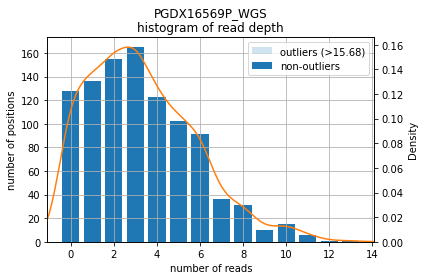

In [9]:
#plot the read depth and outliers
fig,ax = plt.subplots(1)
ax2 = ax.twinx()

bins = max(sampled_counts['read_count'])-min(sampled_counts['read_count'])+1
sampled_counts['read_count'].hist(ax = ax, bins = bins, range = (0,max(sampled_counts['read_count'])+1),  
                                  align = 'left', rwidth = 0.8, color = 'tab:blue', alpha = 0.2, label = 'outliers (>'+str(np.round(upper_limit,2))+')')
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylabel('number of positions')

non_outliers = sampled_counts[(sampled_counts['read_count']<=upper_limit)]
non_outliers['read_count'].hist(ax = ax, bins = bins, range = (0,max(sampled_counts['read_count'])+1),  
                                align = 'left', rwidth = 0.8, color = 'tab:blue', label = 'non-outliers')

#density plot
sampled_counts['read_count'].plot.kde(ax = ax2, color = 'tab:orange', label = 'density')
ylim2 = ax2.get_ylim()
ax2.set_ylim(0,ylim2[1])

ax.set_xlabel('number of reads')
ax.set_title(sample_name+'\n'+'histogram of read depth')
ax.legend()
fig.tight_layout()
plt.savefig(plot_path.rsplit('.',1)[0]+'.read_coverage_distribution.pdf')
plt.show()
plt.close()

del(sampled_counts,random_sample,non_outliers,bins,i)

In [10]:
# #for testing

# start_time = time.time()
# for index in range(len(sampling_set)):
#     map_frequency,map_reads = process_segment(index)
#     break
    
# #for testing
# results_df = pd.DataFrame(pd.Series(np.arange(0,1.01,.01), name = 'mappability'))
# results_df['frequency'] = map_frequency
# results_df['coverage_count'] = map_reads
# results_df

In [11]:
#process arrays in parallel
start_time = time.time()
indexes = np.arange(len(sampling_set))

p = Pool(processes=CPU) #use the available CPU
results = p.map(process_segment, indexes, 1)


interval 19 (chr1:95000000-100000000): 20 of 587 intervals done in 0 min, 12 min remaining
interval 26 (chr1:130000000-135000000) filtered out
interval 27 (chr1:135000000-140000000) filtered out
interval 39 (chr1:195000000-200000000): 40 of 587 intervals done in 0 min, 9 min remaining
interval 59 (chr2:45000000-50000000): 60 of 587 intervals done in 1 min, 9 min remaining
interval 79 (chr2:145000000-150000000): 80 of 587 intervals done in 1 min, 9 min remaining
interval 99 (chr3:0-5000000): 100 of 587 intervals done in 1 min, 9 min remaining
interval 119 (chr3:100000000-105000000): 120 of 587 intervals done in 2 min, 8 min remaining
interval 139 (chr4:0-5000000): 140 of 587 intervals done in 2 min, 8 min remaining
interval 159 (chr4:100000000-105000000): 160 of 587 intervals done in 3 min, 8 min remaining
interval 177 (chr4:190000000-190214555) filtered out
interval 179 (chr5:5000000-10000000): 180 of 587 intervals done in 3 min, 7 min remaining
interval 199 (chr5:105000000-110000000):

In [12]:
#add up the results from the parallel jobs 
map_frequency = np.zeros(101)
map_reads = np.zeros(101)

for i in range(len(results)):
    current_map_frequency,current_map_reads = results[i]    
    map_frequency = map_frequency+current_map_frequency
    map_reads = map_reads+current_map_reads
    
results_df = pd.DataFrame(pd.Series(np.arange(0,101,1), name = 'mappable_percent'))
results_df['frequency'] = map_frequency
results_df['read_count'] = map_reads
results_df = results_df[results_df['frequency']!=0]
results_df['mean_map_bias'] = results_df['read_count'] / results_df['frequency']
results_df['mean_map_bias'] = results_df['mean_map_bias']/np.nanmean(results_df['mean_map_bias'])
results_df

,mappable_percent,frequency,read_count,mean_map_bias
0,0,370781.0,90205.0,0.097930
1,1,4011.0,4837.0,0.485428
2,2,3988.0,4820.0,0.486512
3,3,3938.0,4957.0,0.506693
4,4,4098.0,5300.0,0.520602
...,...,...,...,...
96,96,20603.0,67409.0,1.317010
97,97,21449.0,70992.0,1.332306
98,98,22651.0,74316.0,1.320677
99,99,23783.0,78542.0,1.329342


In [13]:
#get the individual bins and perform lowess smoothing
map_frequency_df = pd.DataFrame(np.array(results)[:,0,:]).copy()
map_reads_df = pd.DataFrame(np.array(results)[:,1,:]).copy()
map_bias_df = map_reads_df/map_frequency_df
print('done converting to dataframe')

map_bias_list = map_bias_df.unstack().reset_index(level=0).copy()
map_bias_list = map_bias_list.rename(columns = {'level_0':'mappable_percent',0:'mappability_bias'})
map_bias_list = map_bias_list[~(map_bias_list['mappability_bias'].isnull())]
print('done reshaping')

regression_line = lowess(endog = map_bias_list['mappability_bias'],exog = map_bias_list['mappable_percent'], 
       frac = 0.04, is_sorted = False, return_sorted = False)

map_bias_list['smoothed_map_bias'] = regression_line

print('done smoothing')

regression_plot_vals = map_bias_list[['mappable_percent','smoothed_map_bias']].drop_duplicates().reset_index(drop=True)

mean_val = np.nanmean(regression_plot_vals['smoothed_map_bias'])

regression_plot_vals['smoothed_map_bias'] = regression_plot_vals['smoothed_map_bias']/mean_val

map_bias_list['mappability_bias'] = map_bias_list['mappability_bias']/mean_val

done converting to dataframe
done reshaping
done smoothing


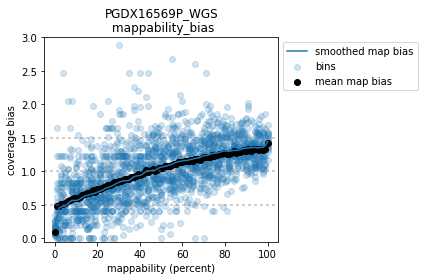

In [14]:
fig,ax = plt.subplots(figsize = (6,4))
random_sample = map_bias_list.sample(2000, random_state = 100)

ax.scatter(random_sample['mappable_percent'],random_sample['mappability_bias'], alpha = 0.2, label = 'bins')
ax.scatter(results_df['mappable_percent'].astype(float), results_df['mean_map_bias'], color = 'black', label = 'mean map bias')
ax.plot(regression_plot_vals['mappable_percent'],regression_plot_vals['smoothed_map_bias'],label = 'smoothed map bias')

ax.legend(loc = 'upper left', bbox_to_anchor = [1,1])
ax.set_xlabel('mappability (percent)')
ax.set_ylabel('coverage bias')
ax.set_title(sample_name+'\n mappability_bias')
ax.axhline(0.5, dashes = [2,2], color = 'grey', alpha = 0.5)
ax.axhline(1.0, dashes = [2,2], color = 'grey', alpha = 0.5)
ax.axhline(1.5, dashes = [2,2], color = 'grey', alpha = 0.5)
ax.set_ylim(-0.05,3)
fig.tight_layout()
fig.savefig(plot_path)


In [15]:
to_export = results_df.merge(regression_plot_vals, on = 'mappable_percent')
to_export.to_csv(output_path,sep='\t', index=False)

In [16]:
#delete temporary files opened by the current session
pybedtools.cleanup(verbose=False, remove_all=True)